In [1]:
# Install YOLOv8 and necessary dependencies
%pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='eb4c4a1fa7eec1ffbabc36420ba1166f797d4ac5')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: faf2001f (faf2001f-university-of-engineering-and-technology-taxila). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Admin\_netrc


True

In [3]:
import os

# Define the root directory path for local Windows system
root_dir = r'C:\ObjectDefectDetection'

# Define paths for the two datasets
v1_dir = os.path.join(root_dir, 'The Welding Defect Dataset')
v2_dir = os.path.join(root_dir, 'The Welding Defect Dataset - v2')

# Print the paths to verify
print(v1_dir)
print(v2_dir)


C:\ObjectDefectDetection\The Welding Defect Dataset
C:\ObjectDefectDetection\The Welding Defect Dataset - v2


In [4]:
print(os.path.exists(v1_dir))  # Should return True if the directory exists
print(os.path.exists(v2_dir))  # Should return True if the directory exists


True
True


In [5]:
# Ensure the YOLOv8 data directories exist
os.makedirs('yolov8/data/welding_v1', exist_ok=True)
os.makedirs('yolov8/data/welding_v2', exist_ok=True)

Displaying some training images from version 1:


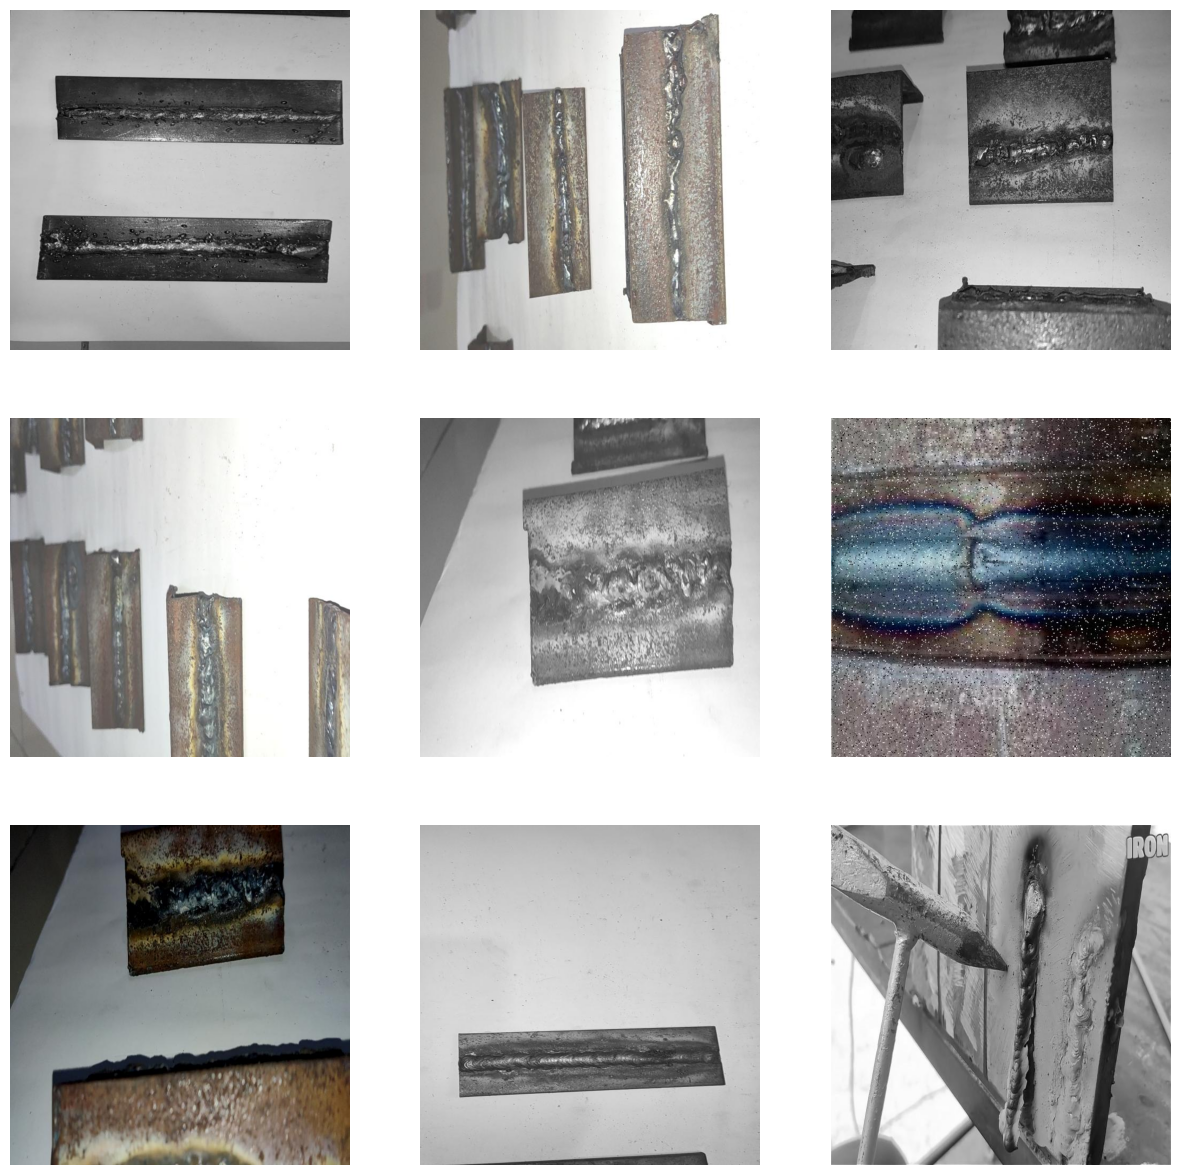

Displaying some training images from version 2:


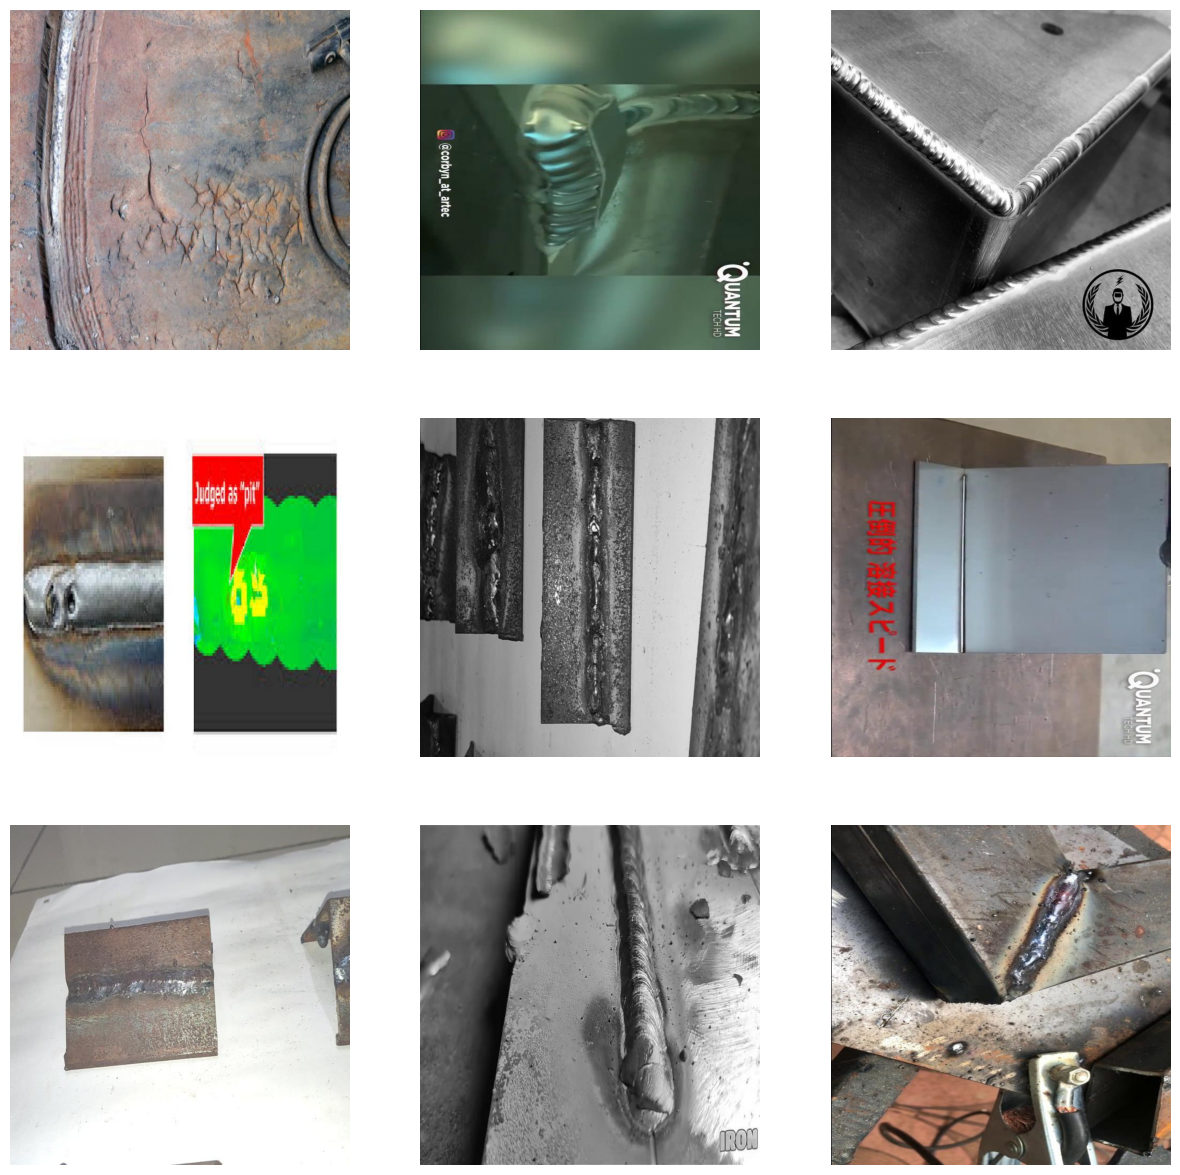

In [6]:
# Function to display images
def display_images(image_dir, num_images=9):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

print("Displaying some training images from version 2:")
display_images(os.path.join(v2_dir, 'train/images'))

In [7]:
# Copy dataset to YOLOv8 directory
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

# Copy version 1 dataset
copy_dataset_to_yolo(v1_dir, 'yolov8/data/welding_v1')

# Copy version 2 dataset
copy_dataset_to_yolo(v2_dir, 'yolov8/data/welding_v2')

In [8]:
import os

# Function to update the paths in the data.yaml file
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()

    # Update the image paths for train, valid, and test
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))

    # Write the updated data back to the file
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# Update data.yaml for version 1 (local system paths)
update_data_yaml(r'C:\ObjectDefectDetection\yolov8\data\welding_v1\data.yaml', r'C:\ObjectDefectDetection\yolov8\data\welding_v1')

# Update data.yaml for version 2 (local system paths)
update_data_yaml(r'C:\ObjectDefectDetection\yolov8\data\welding_v2\data.yaml', r'C:\ObjectDefectDetection\yolov8\data\welding_v2')

# Print and verify updated data.yaml files
def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

# Print updated data.yaml for version 1
print("Updated data.yaml for version 1:")
print_data_yaml(r'C:\ObjectDefectDetection\yolov8\data\welding_v1\data.yaml')

# Print updated data.yaml for version 2
print("Updated data.yaml for version 2:")
print_data_yaml(r'C:\ObjectDefectDetection\yolov8\data\welding_v2\data.yaml')


Updated data.yaml for version 1:
train: C:\ObjectDefectDetection\yolov8\data\welding_v1\train/images
val: C:\ObjectDefectDetection\yolov8\data\welding_v1\valid/images
test: C:\ObjectDefectDetection\yolov8\data\welding_v1\test/images

nc: 3
names: ['Bad Weld', 'Good Weld', 'Defect']


Updated data.yaml for version 2:
train: C:\ObjectDefectDetection\yolov8\data\welding_v2\train/images
val: C:\ObjectDefectDetection\yolov8\data\welding_v2\valid/images
test: C:\ObjectDefectDetection\yolov8\data\welding_v2\test/images

nc: 3
names: ['Bad Weld', 'Good Weld', 'Defect']




In [9]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))
v2_train_labels = load_labels(os.path.join(v2_dir, 'train/labels'))

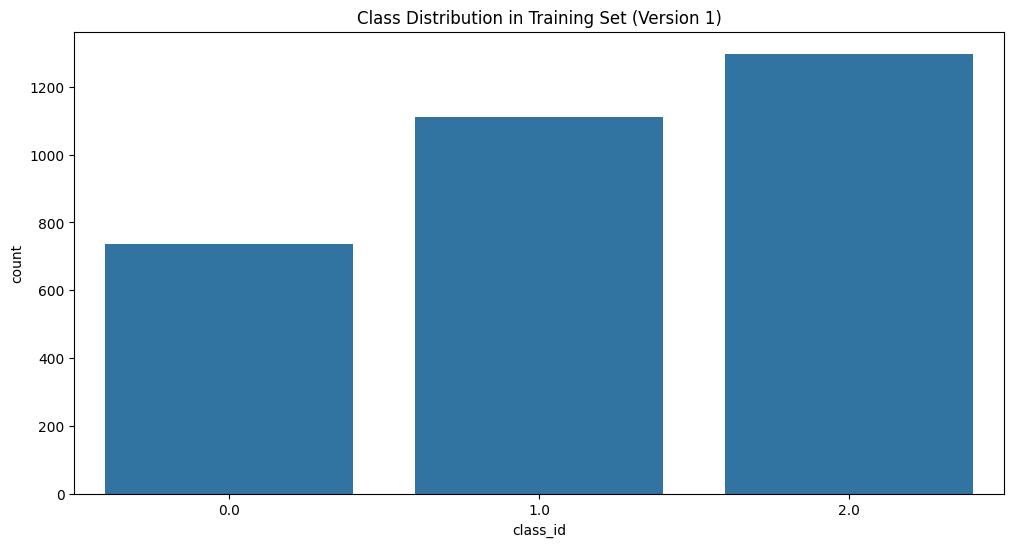

In [10]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

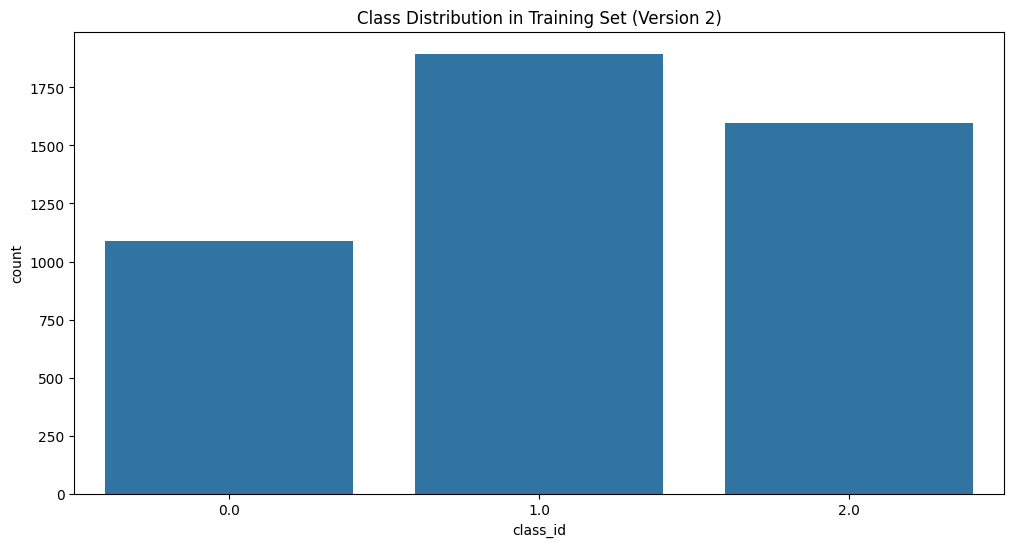

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=v2_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 2)')
plt.show()

In [12]:
# Train YOLOv8 model with augmentation and hyperparameter tuning
# Initialize model
model_v1 = YOLO('yolov8m.pt')  # YOLOv8m (medium) model
model_v2 = YOLO('yolov8m.pt')  # YOLOv8m (medium) model

In [13]:
# Train model on version 1 dataset
model_v1.train(
    data=r'C:\ObjectDefectDetection\yolov8\data\welding_v1\data.yaml', 
    epochs=1, 
    imgsz=6, 
    batch=8, 
    name='welding_v1_aug', 
    lr0=0.01, 
    momentum=0.937, 
    weight_decay=0.0005, 
    warmup_epochs=3.0, 
    warmup_momentum=0.8, 
    warmup_bias_lr=0.1,
    box=0.05, 
    cls=0.5, 
    iou=0.2, 
    hsv_h=0.015, 
    hsv_s=0.7, 
    hsv_v=0.4, 
    translate=0.1, 
    scale=0.5, 
    mosaic=1.0, 
    mixup=0.5
)

# Train model on version 2 dataset
model_v2.train(
    data=r'C:\ObjectDefectDetection\yolov8\data\welding_v2\data.yaml', 
    epochs=1, 
    imgsz=6, 
    batch=8, 
    name='welding_v2_aug', 
    lr0=0.01, 
    momentum=0.937, 
    weight_decay=0.0005, 
    warmup_epochs=3.0, 
    warmup_momentum=0.8, 
    warmup_bias_lr=0.1,
    box=0.05, 
    cls=0.5, 
    iou=0.2, 
    hsv_h=0.015, 
    hsv_s=0.7, 
    hsv_v=0.4, 
    translate=0.1, 
    scale=0.5, 
    mosaic=1.0, 
    mixup=0.5
)


Ultralytics YOLOv8.2.95  Python-3.12.2 torch-2.4.1+cpu CPU (Intel Core(TM) i5-6300U 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=C:\ObjectDefectDetection\yolov8\data\welding_v1\data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=6, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=welding_v1_aug5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

Freezing layer 'model.22.dfl.conv.weight'
WARNING  imgsz=[6] must be multiple of max stride 32, updating to [32]


train: Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\train\labels...:   0%|          | 0/839 [00:00<?, ?it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\train\labels... 9 images, 0 backgrounds, 0 corrupt:   1%|          | 9/839 [00:00<00:09, 86.03it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\train\labels... 18 images, 0 backgrounds, 0 corrupt:   2%|▏         | 18/839 [00:00<00:09, 86.18it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\train\labels... 27 images, 0 backgrounds, 0 corrupt:   3%|▎         | 27/839 [00:00<00:09, 83.48it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\train\labels... 37 images, 0 backgrounds, 0 corrupt:   4%|▍         | 37/839 [00:00<00:09, 87.94it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\train\labels... 46 images, 0 backgrounds, 0 corrupt:   5%|▌         | 46/839 [00:00<00:09, 87.79it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\train\labels... 57 images, 0 backgr

train: New cache created: C:\ObjectDefectDetection\yolov8\data\welding_v1\train\labels.cache


val: Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\valid\labels...:   0%|          | 0/176 [00:00<?, ?it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\valid\labels... 8 images, 0 backgrounds, 0 corrupt:   5%|▍         | 8/176 [00:00<00:02, 76.45it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\valid\labels... 16 images, 0 backgrounds, 0 corrupt:   9%|▉         | 16/176 [00:00<00:02, 70.68it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\valid\labels... 24 images, 0 backgrounds, 0 corrupt:  14%|█▎        | 24/176 [00:00<00:02, 68.74it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\valid\labels... 32 images, 0 backgrounds, 0 corrupt:  18%|█▊        | 32/176 [00:00<00:02, 71.91it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\valid\labels... 40 images, 0 backgrounds, 0 corrupt:  23%|██▎       | 40/176 [00:00<00:01, 73.41it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v1\valid\labels... 50 images, 0 backgrou

val: New cache created: C:\ObjectDefectDetection\yolov8\data\welding_v1\valid\labels.cache
Plotting labels to runs\detect\welding_v1_aug5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to runs\detect\welding_v1_aug5
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      0.027      2.897      1.243         36         32: 100%|██████████| 105/105 [02:50<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


                   all        176        573      0.015    0.00921    0.00189   0.000405

1 epochs completed in 0.058 hours.
Optimizer stripped from runs\detect\welding_v1_aug5\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\welding_v1_aug5\weights\best.pt, 52.0MB

Validating runs\detect\welding_v1_aug5\weights\best.pt...
Ultralytics YOLOv8.2.95  Python-3.12.2 torch-2.4.1+cpu CPU (Intel Core(TM) i5-6300U 2.40GHz)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


                   all        176        573     0.0146    0.00921    0.00189   0.000404
              Bad Weld         87        127    0.00214    0.00787    0.00246   0.000399
             Good Weld        119        253     0.0417     0.0198    0.00319   0.000814
                Defect         90        193          0          0          0          0
Speed: 0.1ms preprocess, 24.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\welding_v1_aug5


Ultralytics YOLOv8.2.95  Python-3.12.2 torch-2.4.1+cpu CPU (Intel Core(TM) i5-6300U 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=C:\ObjectDefectDetection\yolov8\data\welding_v2\data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=6, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=welding_v2_aug3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

Freezing layer 'model.22.dfl.conv.weight'
WARNING  imgsz=[6] must be multiple of max stride 32, updating to [32]


train: Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\train\labels...:   0%|          | 0/1619 [00:00<?, ?it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\train\labels... 2 images, 0 backgrounds, 0 corrupt:   0%|          | 2/1619 [00:00<01:29, 18.12it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\train\labels... 4 images, 0 backgrounds, 0 corrupt:   0%|          | 4/1619 [00:00<01:30, 17.75it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\train\labels... 6 images, 0 backgrounds, 0 corrupt:   0%|          | 6/1619 [00:00<02:05, 12.86it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\train\labels... 9 images, 0 backgrounds, 0 corrupt:   1%|          | 9/1619 [00:00<01:35, 16.92it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\train\labels... 18 images, 0 backgrounds, 0 corrupt:   1%|          | 18/1619 [00:00<00:44, 36.18it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\train\labels... 28 images, 0 backgr

train: New cache created: C:\ObjectDefectDetection\yolov8\data\welding_v2\train\labels.cache


val: Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\valid\labels...:   0%|          | 0/283 [00:00<?, ?it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\valid\labels... 1 images, 0 backgrounds, 0 corrupt:   0%|          | 1/283 [00:00<00:35,  7.95it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\valid\labels... 4 images, 0 backgrounds, 0 corrupt:   1%|▏         | 4/283 [00:00<00:17, 15.73it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\valid\labels... 7 images, 0 backgrounds, 0 corrupt:   2%|▏         | 7/283 [00:00<00:14, 19.47it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\valid\labels... 17 images, 0 backgrounds, 0 corrupt:   6%|▌         | 17/283 [00:00<00:05, 44.70it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\valid\labels... 25 images, 0 backgrounds, 0 corrupt:   9%|▉         | 25/283 [00:00<00:04, 53.39it/s]Scanning C:\ObjectDefectDetection\yolov8\data\welding_v2\valid\labels... 31 images, 0 backgrounds,

val: New cache created: C:\ObjectDefectDetection\yolov8\data\welding_v2\valid\labels.cache
Plotting labels to runs\detect\welding_v2_aug3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to runs\detect\welding_v2_aug3
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G    0.02917      2.872      1.448          9         32: 100%|██████████| 203/203 [04:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


                   all        283        802      0.346     0.0175    0.00807    0.00229

1 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\welding_v2_aug3\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\welding_v2_aug3\weights\best.pt, 52.0MB

Validating runs\detect\welding_v2_aug3\weights\best.pt...
Ultralytics YOLOv8.2.95  Python-3.12.2 torch-2.4.1+cpu CPU (Intel Core(TM) i5-6300U 2.40GHz)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:39<00:00,  2.21s/it]


                   all        283        802      0.347     0.0177    0.00793    0.00226
              Bad Weld        141        194    0.00913     0.0103    0.00824    0.00185
             Good Weld        175        335     0.0304     0.0429     0.0155    0.00492
                Defect        128        273          1          0          0          0
Speed: 0.2ms preprocess, 108.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\welding_v2_aug3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000012512932B70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

Displaying results from model trained on version 1 with augmentation:

image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset\test\images\good-stick-welds_38_jpeg_jpg.rf.a798a6f14879da205dac297a653d167f.jpg: 32x32 1 Good Weld, 57.8ms
Speed: 1.0ms preprocess, 57.8ms inference, 3.0ms postprocess per image at shape (1, 3, 32, 32)


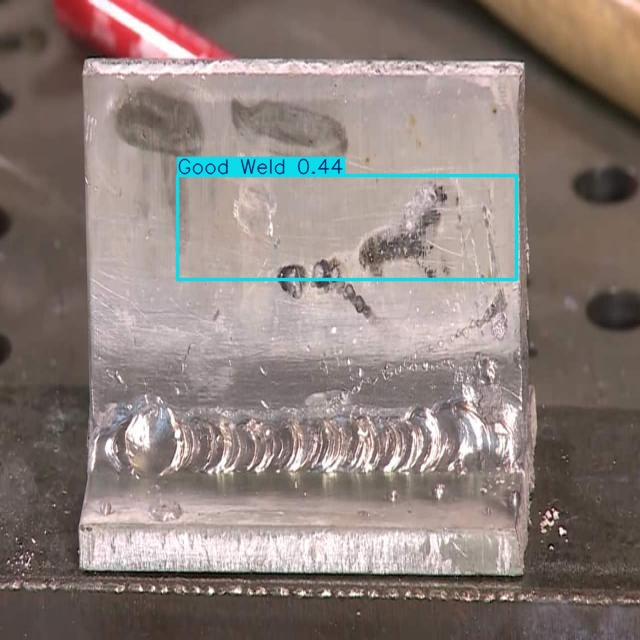


image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset\test\images\good_weld_vid2265_jpeg_jpg.rf.8a70ab5ca12dc7c63f19d1dadeaddaa5.jpg: 32x32 2 Good Welds, 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 3.0ms postprocess per image at shape (1, 3, 32, 32)


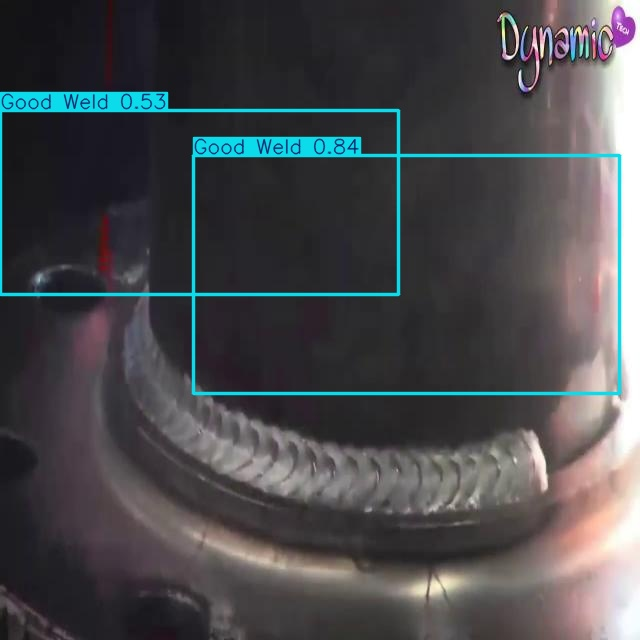


image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset\test\images\mig-good-welds_11_jpeg_jpg.rf.c488ebd180387fc1f20114bed459fbb5.jpg: 32x32 1 Good Weld, 60.5ms
Speed: 1.0ms preprocess, 60.5ms inference, 2.0ms postprocess per image at shape (1, 3, 32, 32)


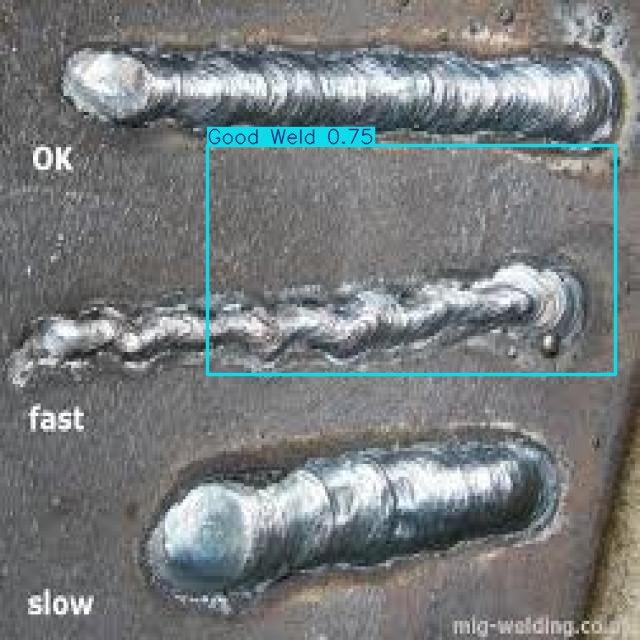


image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset\test\images\good_weld_vid104_jpeg_jpg.rf.892dcfa6c4ff7737002a45507ebace2b.jpg: 32x32 3 Good Welds, 64.8ms
Speed: 0.0ms preprocess, 64.8ms inference, 4.0ms postprocess per image at shape (1, 3, 32, 32)


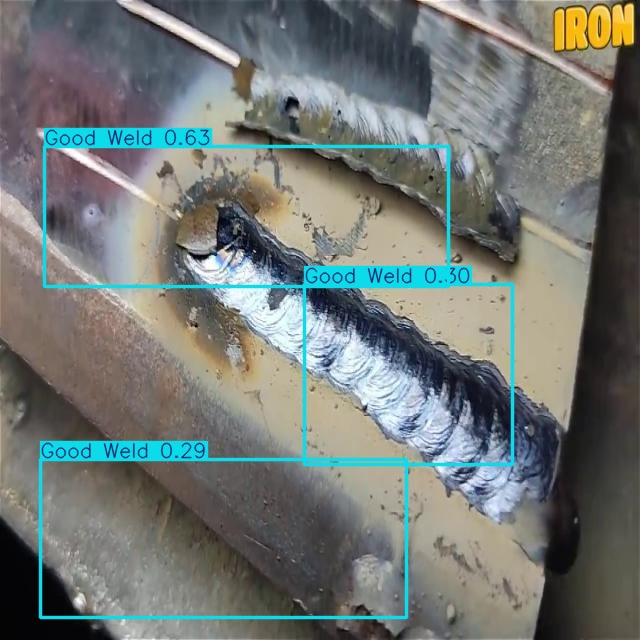


image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset\test\images\SampleV1_1_mp4-1_jpg.rf.3f50c974a91c4e6348dd49491f06def8.jpg: 32x32 (no detections), 82.5ms
Speed: 1.0ms preprocess, 82.5ms inference, 1.0ms postprocess per image at shape (1, 3, 32, 32)


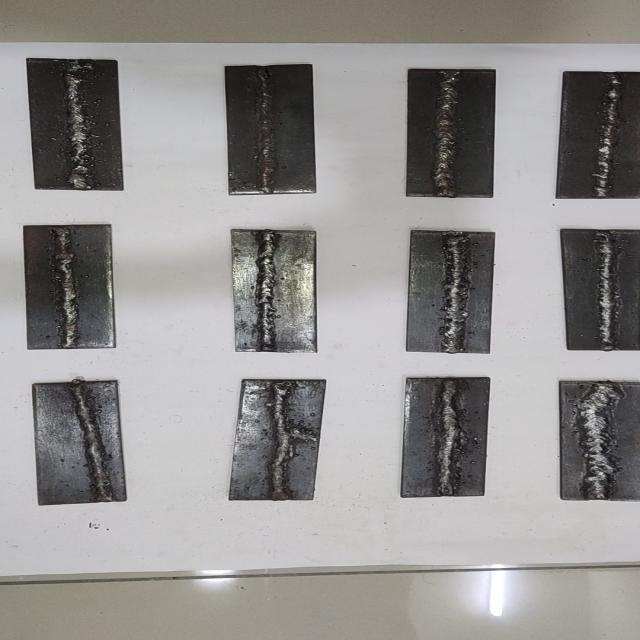

Displaying results from model trained on version 2 with augmentation:

image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset - v2\test\images\Good-Welding-images_12_jpeg_jpg.rf.9fa5a26596733b74baf1f974b8210c28.jpg: 32x32 1 Good Weld, 44.9ms
Speed: 1.0ms preprocess, 44.9ms inference, 2.0ms postprocess per image at shape (1, 3, 32, 32)


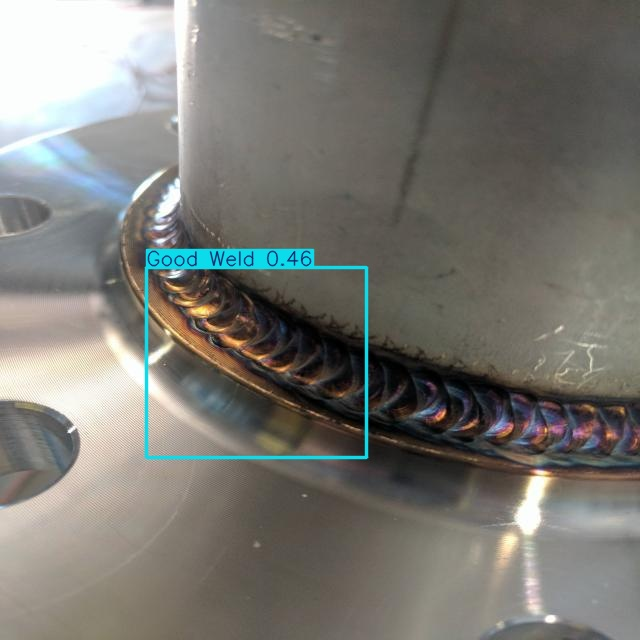


image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset - v2\test\images\Slag-inclusion-welding-images_5_jpeg_jpg.rf.0e134d6e310d401ae657279a12daa898.jpg: 32x32 1 Good Weld, 37.9ms
Speed: 0.0ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 32, 32)


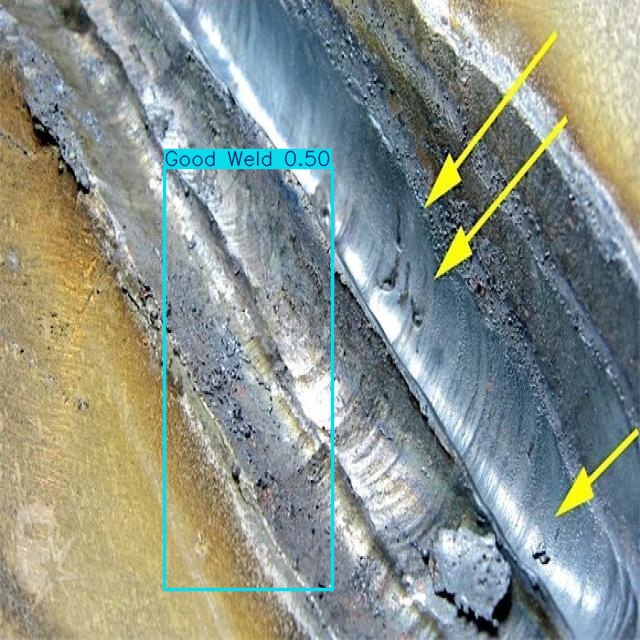


image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset - v2\test\images\Good-Welding-images_17_jpeg_jpg.rf.be58c70a9f7f542fc89cb48847776741.jpg: 32x32 1 Good Weld, 44.9ms
Speed: 0.0ms preprocess, 44.9ms inference, 2.0ms postprocess per image at shape (1, 3, 32, 32)


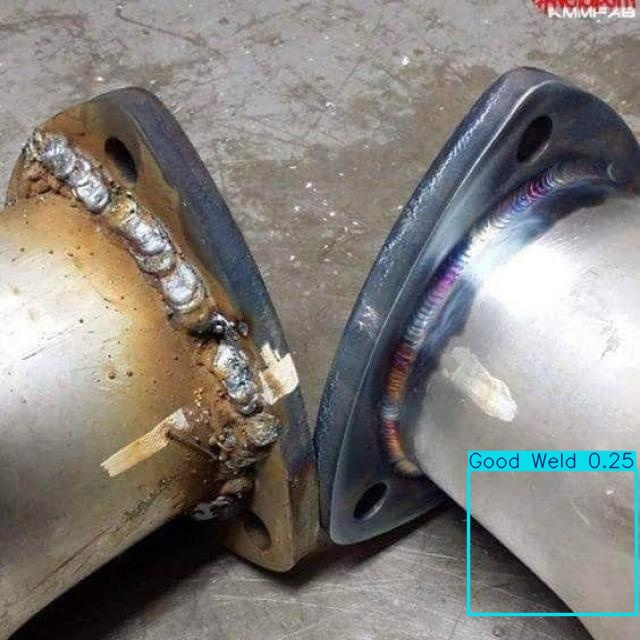


image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset - v2\test\images\Screenshot-2022-12-05-224335_jpeg_jpg.rf.bcfe0035e76676a1f9056aea47c18999.jpg: 32x32 1 Good Weld, 66.4ms
Speed: 1.0ms preprocess, 66.4ms inference, 2.0ms postprocess per image at shape (1, 3, 32, 32)


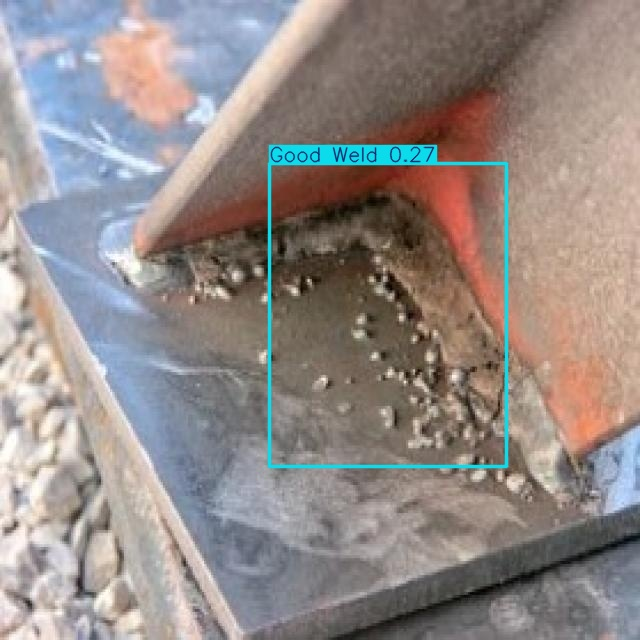


image 1/1 C:\ObjectDefectDetection\The Welding Defect Dataset - v2\test\images\good_weld_vid1134_jpeg_jpg.rf.5531f5eb2fc03e6b2b992469c012caa4.jpg: 32x32 1 Bad Weld, 59.7ms
Speed: 1.0ms preprocess, 59.7ms inference, 2.0ms postprocess per image at shape (1, 3, 32, 32)


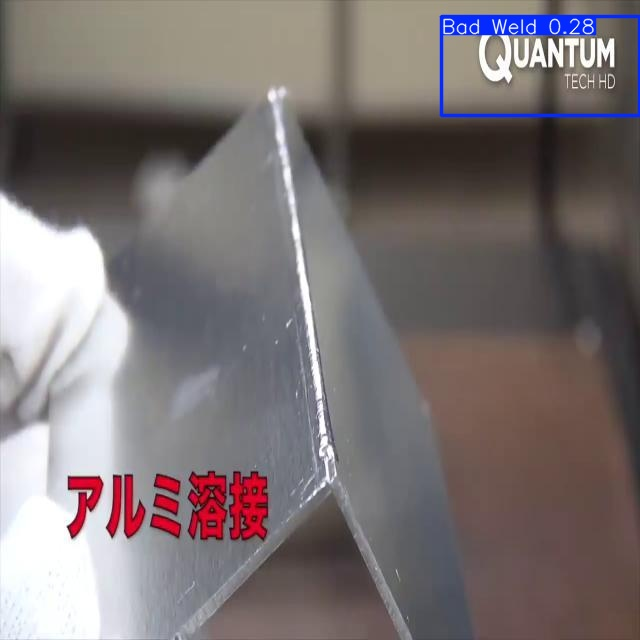

In [14]:
# Evaluate the model and display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print("Displaying results from model trained on version 1 with augmentation:")
display_results(model_v1, os.path.join(v1_dir, 'test/images'))

print("Displaying results from model trained on version 2 with augmentation:")
display_results(model_v2, os.path.join(v2_dir, 'test/images'))
